In [1]:
# Importando os pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%% Importando o banco de dados
acidentes = pd.read_excel('/home/usp_ds_analytics/revisao_supervised/data/acidentes.xlsx')
## Fonte: Fávero e Belfiore (2024) Manual de Análise de Dados, Capítulo 14

acidentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   acidentes  100 non-null    int64  
 1   pop        100 non-null    float64
 2   idade      100 non-null    float64
 3   leiseca    100 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 3.3 KB


In [3]:
# Variáveis métricas
acidentes[['acidentes', 'pop', 'idade']].describe()

,acidentes,pop,idade
count,100.000000,100.000000,100.00000
mean,3.010000,1.774185,50.12270
std,6.557431,0.769494,7.69488
min,0.000000,0.650289,24.00000
25%,0.000000,1.353586,47.77250
50%,0.000000,1.463477,51.75500
75%,3.000000,2.300476,54.94750
max,33.000000,2.867504,61.00000


In [4]:
# Variável categórica
acidentes['leiseca'].value_counts()

leiseca
0    58
1    42
Name: count, dtype: int64

In [5]:
# Tabela de frequências de Y
acidentes['acidentes'].value_counts().sort_index()

acidentes
0     58
1      8
2      6
3      6
4      4
5      3
6      2
7      1
8      2
9      2
10     1
14     1
16     1
20     1
25     1
30     1
31     1
33     1
Name: count, dtype: int64

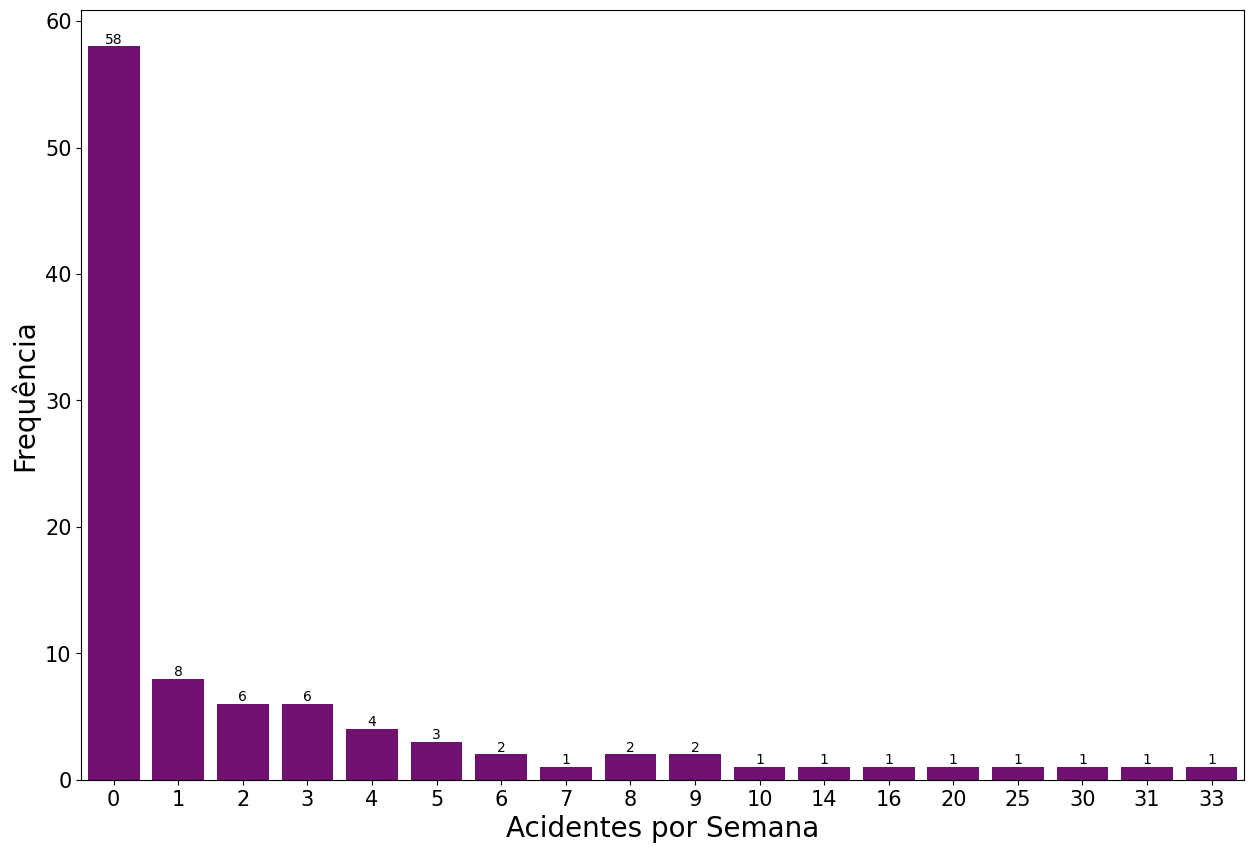

In [6]:
#%% Histograma da variável dependente
plt.figure(figsize=(15,10))
ax = sns.barplot(data = acidentes['acidentes'].value_counts().sort_index(), color='purple')
ax.bar_label(ax.containers[0])
plt.xlabel('Acidentes por Semana', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [7]:
#%% Comparação média x variância da variável dependente

print(f"Média: {round(acidentes['acidentes'].mean(), 2)}")
print(f"Variância: {round(acidentes['acidentes'].var(), 2)}")

# Variância consideravelmente maior do que a média!


Média: 3.01
Variância: 43.0


In [8]:
#%% Organização dos dados para os modelos "zero inflated"
## É necessária a separação entre os componentes (contagem e zero inflated)

# Variável dependente
y = acidentes['acidentes']

# Variáveis preditoras: componente de contagem
x1 = acidentes['pop']
X1 = sm.add_constant(x1)

# Variáveis preditoras: componente logit (zero inflated)
x2 = acidentes[['idade', 'leiseca']]
X2 = sm.add_constant(x2)

In [9]:
#%% Modelo Zero Inflated Poisson 

# Estimando o modelo
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                    inflation='logit').fit()

# Parâmetros do modelo
modelo_zip.summary()

         Current function value: 2.560484
         Iterations: 35
         Function evaluations: 67
         Gradient evaluations: 67


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:               acidentes   No. Observations:                  100
Model:             ZeroInflatedPoisson   Df Residuals:                       98
Method:                            MLE   Df Model:                            1
Date:                 Tue, 24 Sep 2024   Pseudo R-squ.:                  0.1343
Time:                         19:49:37   Log-Likelihood:                -256.05
converged:                       False   LL-Null:                       -295.79
Covariance Type:             nonrobust   LLR p-value:                 4.877e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const     -11.7276      3.029     -3.872      0.000     -17.664      -5.791
inflate_idade       0.2252      0.058      3.857      0.000       0.111       0.340
inflate_leiseca     1.7255      0.553      3.123      0.002       0.642       2.809
const               0.9333      0.198      4.712      0.000       0.545       1.322
pop                 0.5039      0.086      5.848      0.000       0.335       0.673
===================================================================================
"""

In [10]:
# Valores preditos pelo modelo para observações da amostra
acidentes['poisson_zi'] = modelo_zip.predict(X1, exog_infl=X2)

In [11]:
#%% Modelo Poisson (comparação)

modelo_poisson = sm.Poisson.from_formula(formula='acidentes ~ pop', 
                                         data=acidentes).fit()

# Parâmetros do modelo
modelo_poisson.summary()

Optimization terminated successfully.
         Current function value: 4.488922
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:              acidentes   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Sep 2024   Pseudo R-squ.:                 0.08185
Time:                        19:49:37   Log-Likelihood:                -448.89
converged:                       True   LL-Null:                       -488.91
Covariance Type:            nonrobust   LLR p-value:                 3.684e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2776      0.185     -1.497      0.134      -0.641       0.086
pop            0.6986      0.081      8.585      0.000       0.539       0.858
==============================================================================
"""

In [12]:
# Valores preditos pelo modelo para observações da amostra
acidentes['poisson'] = modelo_poisson.predict()

In [13]:
#%% Teste de Vuong (definição da função)
# VUONG, Q. H. Likelihood ratio tests for model selection and non-nested
#hypotheses. Econometrica, v. 57, n. 2, p. 307-333, 1989.

# Definição de função para elaboração do teste de Vuong
# Autores: Luiz Paulo Fávero e Helder Prado Santos

def vuong_test(m1, m2):

    from scipy.stats import norm    

    if m1.__class__.__name__ == "GLMResultsWrapper":
        
        glm_family = modelo_poisson.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()
            
        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]
    
    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
        
    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
    
    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")
        
    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))        

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]    
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [14]:
#%% Teste de Vuong (aplicação aos dados)
vuong_test(modelo_zip, modelo_poisson)

# O resultado teste evidencia a inflação de zeros

Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: 4.212
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [15]:
#%% Teste de razão de verossimilhança

# Definição da função 'lrtest'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 3)
    print(f"χ²: {round(LR_statistic,2)}"), print(f"p-valor: {round(p_val,2)}")
    if p_val <= 0.05:
        print("H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood")
    else:
        print("H0: Modelos com log-likelihoods que não são estatisticamente diferentes ao nível de confiança de 95%")

# Teste de razão de verossimilhança: Poisson GLM e ZI Poisson
lrtest([modelo_poisson, modelo_zip])

χ²: 385.69
p-valor: 0.0
H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood


In [16]:
#%% Modelo ZI Binomial Negativo

# Estimando o modelo
modelo_zibn = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2,
                                            inflation='logit').fit(method='nm', maxiter=1000)

# Parâmetros do modelo
modelo_zibn.summary()

# Interpretando o 'alpha'

# Se o p-valor alpha < nível de sig., é estatisticamente diferente de zero
# Portanto, observa-se superdispersão na variável dependente!

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                         acidentes   No. Observations:                  100
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       98
Method:                                      MLE   Df Model:                            1
Date:                           Tue, 24 Sep 2024   Pseudo R-squ.:                  0.1236
Time:                                   19:49:38   Log-Likelihood:                -164.40
converged:                                 False   LL-Null:                       -187.59
Covariance Type:                       nonrobust   LLR p-value:                 9.801e-12
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const     -16.2373      5.727     -2.835      0.005     -27.462      -5.013
inflate_idade       0.2882      0.100      2.885      0.004       0.092       0.484
inflate_leiseca     2.8590      1.077      2.656      0.008       0.749       4.969
const               0.0253      0.540      0.047      0.963      -1.034       1.084
pop                 0.8662      0.262      3.304      0.001       0.352       1.380
alpha               1.2712      0.399      3.187      0.001       0.490       2.053
===================================================================================
"""

In [17]:
# Valores preditos pelo modelo para observações da amostra
acidentes['bn_zi'] = modelo_zibn.predict(X1, exog_infl=X2)

In [18]:
#%% Modelo Binomial Negativo (comparação)

modelo_bn = sm.NegativeBinomial.from_formula(formula='acidentes ~ pop', 
                                             data=acidentes).fit()

# Parâmetros do modelo
modelo_bn.summary()

# Interpretando o 'alpha'

# Se o p-valor alpha < nível de sig., é estatisticamente diferente de zero
# Portanto, observa-se superdispersão na variável dependente!

Optimization terminated successfully.
         Current function value: 1.848073
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:              acidentes   No. Observations:                  100
Model:               NegativeBinomial   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Sep 2024   Pseudo R-squ.:                 0.01594
Time:                        19:49:38   Log-Likelihood:                -184.81
converged:                       True   LL-Null:                       -187.80
Covariance Type:            nonrobust   LLR p-value:                   0.01440
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4228      0.602     -0.702      0.483      -1.604       0.758
pop            0.7729      0.310      2.493      0.013       0.165       1.381
alpha          4.4854      0.927      4.838      0.000       2.668       6.303
==============================================================================
"""

In [19]:
# Valores preditos pelo modelo para observações da amostra
acidentes['bn'] = modelo_bn.predict()

In [20]:
#%% Teste de razão de verossimilhança

# Definição da função 'lrtest'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 3)
    print(f"χ²: {round(LR_statistic,2)}"), print(f"p-valor: {round(p_val,2)}")
    if p_val <= 0.05:
        print("H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood")
    else:
        print("H0: Modelos com log-likelihoods que não são estatisticamente diferentes ao nível de confiança de 95%")

# Teste de razão de verossimilhança: Binomial Negativo GLM e ZIBN
lrtest([modelo_bn, modelo_zibn])

χ²: 40.81
p-valor: 0.0
H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood


In [21]:
#%% Teste de razão de verossimilhança

# Definição da função 'lrtest'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    print(f"χ²: {round(LR_statistic,2)}"), print(f"p-valor: {round(p_val,2)}")
    if p_val <= 0.05:
        print("H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood")
    else:
        print("H0: Modelos com log-likelihoods que não são estatisticamente diferentes ao nível de confiança de 95%")

# Teste de razão de verossimilhança: ZIP e ZIBN
lrtest([modelo_zip, modelo_zibn])

χ²: 183.29
p-valor: 0.0
H1: Modelos diferentes, favorecendo aquele com a maior Log-Likelihood


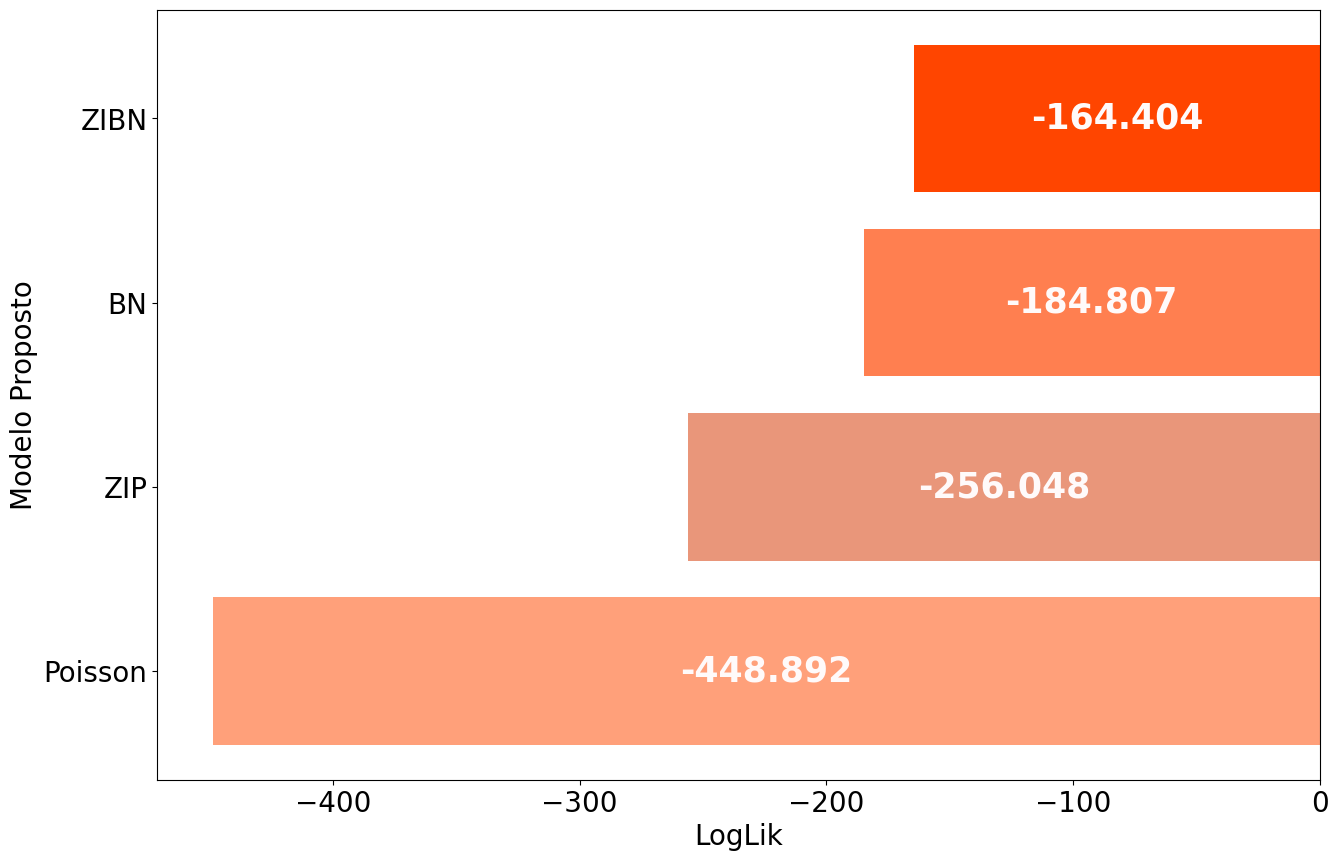

In [22]:
#%% Visualizando graficamente as loglik

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['ZIP','ZIBN', 'Poisson', 'BN'],
                       'loglik':[modelo_zip.llf, 
                                 modelo_zibn.llf, 
                                 modelo_poisson.llf, 
                                 modelo_bn.llf]}).sort_values(by=['loglik'])

# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(15,10))

c = ['lightsalmon', 'darksalmon', 'coral', 'orangered']

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='snow', fontsize=25, weight='bold')
ax.set_ylabel("Modelo Proposto", fontsize=20)
ax.set_xlabel("LogLik", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [23]:
#%% Realizando predições no modelo ZIBN
pred_zibn = modelo_zibn.predict(pd.DataFrame({'const': [1],
                                              'pop': [1.5]}),
                                exog_infl=pd.DataFrame({'const': [1],
                                                        'idade': [38],
                                                        'leiseca': [1]}))

print(f"Quant. Estimada de Acidentes por Semana: {round(pred_zibn[0], 2)}")

Quant. Estimada de Acidentes por Semana: 3.46


### Comparando as previsões dos modelos

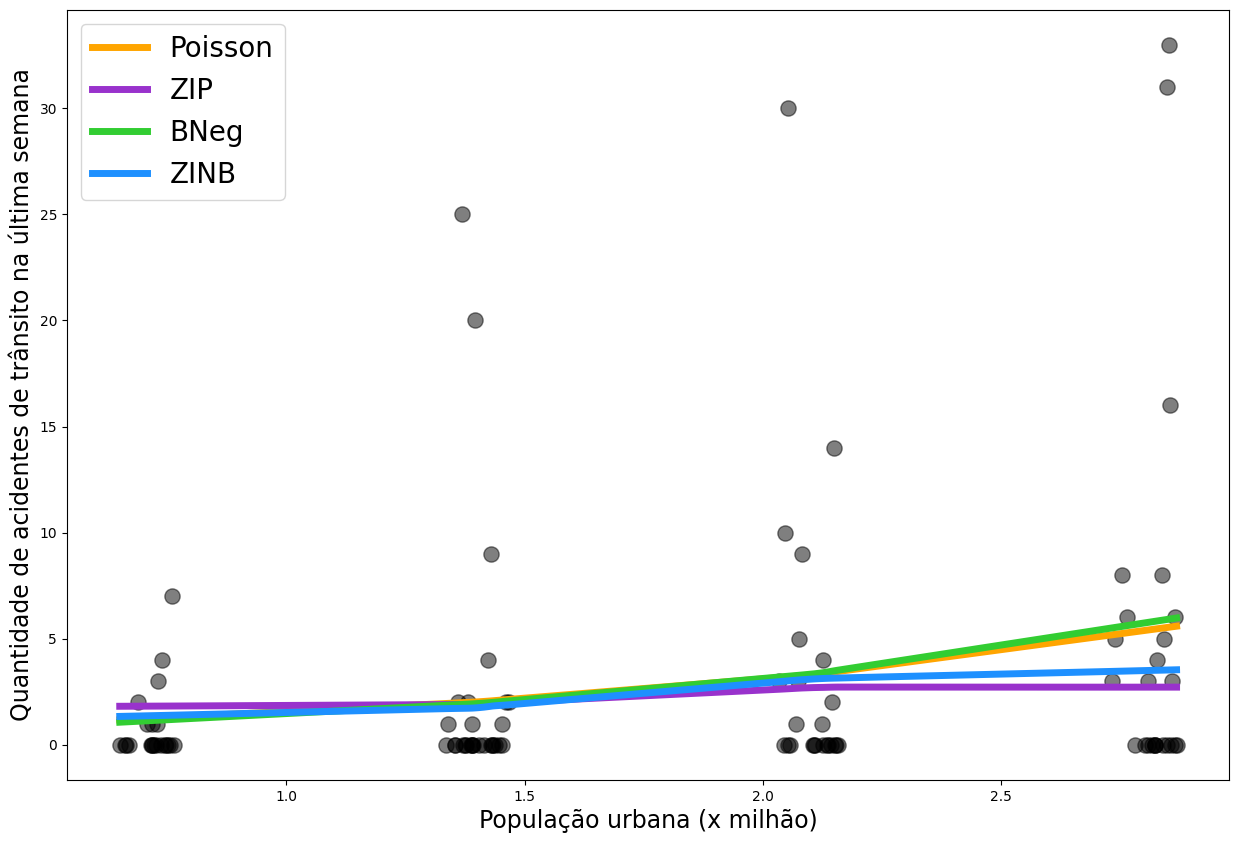

In [24]:
plt.figure(figsize=(15,10))
sns.regplot(data=acidentes, x=acidentes['pop'], y=acidentes['poisson'],
            ci=None, marker='o', lowess=True, scatter=False,
            label='Poisson',
            line_kws={'color':'orange', 'linewidth':5})
sns.regplot(data=acidentes, x=acidentes['pop'], y=acidentes['poisson_zi'],
            ci=None, marker='o', lowess=True, scatter=False,
            label='ZIP',
            line_kws={'color':'darkorchid', 'linewidth':5})
sns.regplot(data=acidentes, x=acidentes['pop'], y=acidentes['bn'],
            ci=None, marker='o', lowess=True, scatter=False,
            label='BNeg',
            line_kws={'color':'limegreen', 'linewidth':5})
sns.regplot(data=acidentes, x=acidentes['pop'], y=acidentes['bn_zi'],
            ci=None, marker='o', lowess=True, scatter=False,
            label='ZINB',
            line_kws={'color':'dodgerblue', 'linewidth':5})
sns.regplot(data=acidentes, x=acidentes['pop'], y=acidentes['acidentes'],
            ci=None, marker='o', fit_reg=False,
            scatter_kws={'color':'black', 's':120, 'alpha':0.5})
plt.xlabel('População urbana (x milhão)', fontsize=17)
plt.ylabel('Quantidade de acidentes de trânsito na última semana', fontsize=17)
plt.legend(fontsize=20)
plt.show()